## Matrix Profiler - Machie temperature system failure (NAB)
Prima di utilizzare questo script, bisogna caricare il file csv dei dati [machine_temperature_system_failure.csv](https://drive.google.com/file/d/1-P2RkOALR9EF2oqA4D8jdlVxVaqtGdej/view?usp=sharing).
Siccome l'algoritmo di Matrix Profiler non è presente su Colab, bisogna installarlo (forse richiede un riavvio del runtime).

### Anomalie
Ci sono 3 anomalie nel dataset caricato:
* 2 anomalie spaziali
* 1 anomalia temporale

In [1]:
# Installazione librerie MP
!pip install matrixprofile

In [2]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matrixprofile as mp
import datetime as dt

In [94]:
# Costanti
DATASET_PATH = 'machine_temperature_system_failure.csv'
# Dati presi ogni 5 minuti. Finestra temporale di 1  ora
#PROFILE_WINDOW = 12
#PROFILE_WINDOW = 24
#PROFILE_WINDOW = 12 * 12
PROFILE_WINDOW = 12 * 24
#PROFILE_WINDOW = 12 * 36
#PROFILE_WINDOW = 12 * 48

In [95]:
# Caricamento dataset
temperatures = pd.read_csv(DATASET_PATH)
temperatures.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [96]:
# Recupero array di valori dei dati
dataset = np.array(temperatures['value'])
dataset

array([73.96732207, 74.935882  , 76.12416182, ..., 97.13546835,
       98.05685212, 96.90386085])

## Analisi dei dati con MP

In [97]:
# Creazione Matrix Profile
temp_profile = mp.compute(dataset, windows=PROFILE_WINDOW)
temp_profile

{'algorithm': 'mpx',
 'class': 'MatrixProfile',
 'data': {'query': None,
  'ts': array([73.96732207, 74.935882  , 76.12416182, ..., 97.13546835,
         98.05685212, 96.90386085])},
 'ez': 0,
 'join': False,
 'lmp': None,
 'lpi': None,
 'metric': 'euclidean',
 'mp': array([13.14255142, 13.07557934, 13.01718403, ..., 14.46110802,
        14.43942113, 14.41517475]),
 'pi': array([7514, 7517, 7518, ..., 7843, 7844, 7845]),
 'rmp': None,
 'rpi': None,
 'sample_pct': 1,
 'w': 288}

In [98]:
# Ricerca delle anomalie nei dati - Zona di esclusione di 1 giorni tra le anomalie. Di default l'algoritmo ne ricerca 3
temp_profile = mp.discover.discords(temp_profile, k=3, exclusion_zone=PROFILE_WINDOW*2)
temp_profile['discords']

array([ 3354, 20186, 13550])

/usr/local/lib/python3.7/dist-packages/matrixprofile/visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


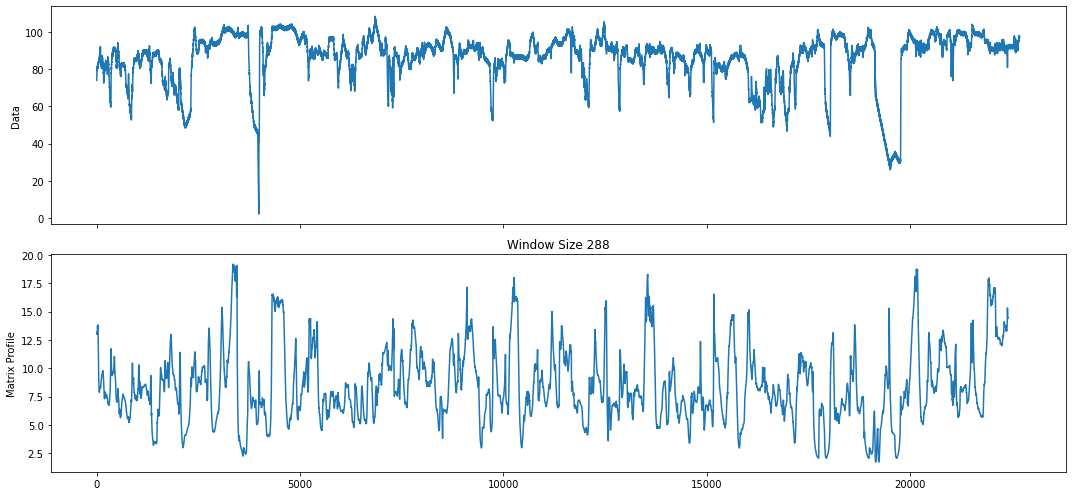

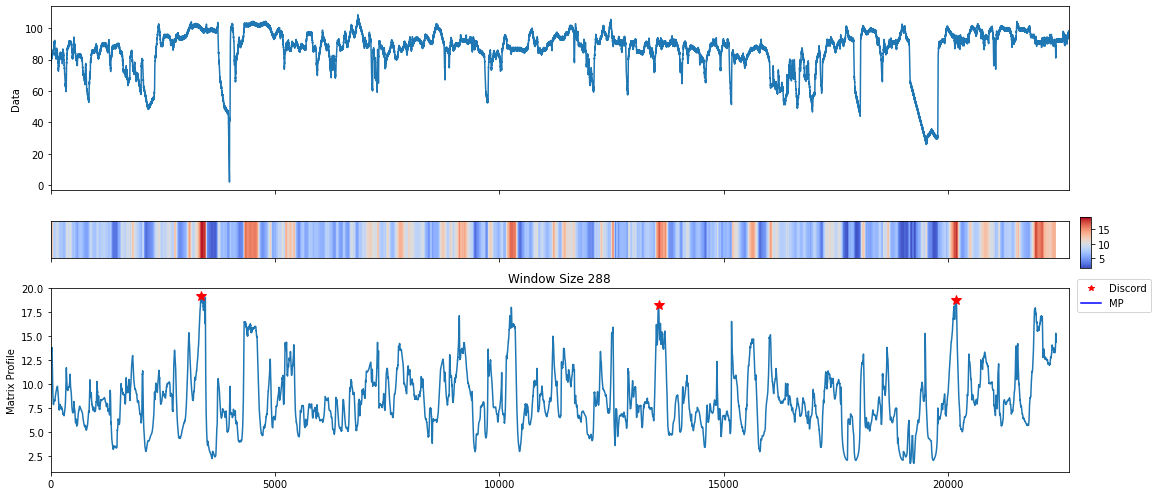

In [99]:
# Plot dei grafici del MP
figures = mp.visualize(temp_profile)

In [100]:
# Recupero valori delle date delle anomalie
temperatures['timestamp'][temp_profile['discords']]

3354     2013-12-14 12:45:00
20186    2014-02-10 22:25:00
13550    2014-01-18 21:25:00
Name: timestamp, dtype: object

In [101]:
discords_timestamps = []
for i in temp_profile['discords']:
  discords_timestamps.append(temperatures.at[i, 'timestamp'])

discords_timestamps = pd.to_datetime(discords_timestamps)
discords_timestamps

DatetimeIndex(['2013-12-14 12:45:00', '2014-02-10 22:25:00',
               '2014-01-18 21:25:00'],
              dtype='datetime64[ns]', freq=None)

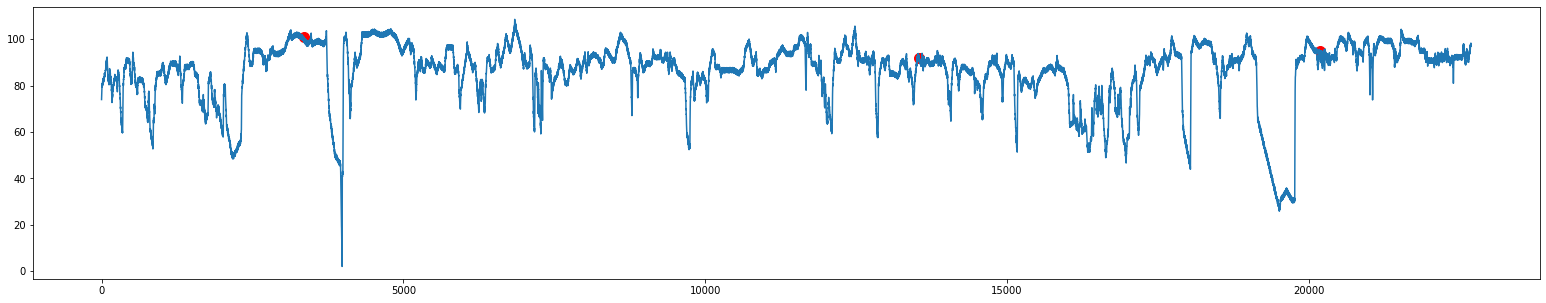

In [102]:
# Plot anomalie sul dataset originale
plt.figure(figsize=(27,5))
plt.plot(np.arange(len(temperatures['value'])), temperatures['value'])
plt.scatter(temp_profile['discords'], temperatures['value'][temp_profile['discords']], color='red', s=100)
plt.show()

In [103]:
figures[1].savefig('MP_Temperature_1D.png')

In [104]:
temp2 = pd.read_csv(DATASET_PATH, index_col=0)
temp2.index = pd.to_datetime(temp2.index)
temp2.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [105]:
temp2['value'][discords_timestamps]

timestamp
2013-12-14 12:45:00    100.923099
2014-02-10 22:25:00     94.807879
2014-01-18 21:25:00     91.778704
Name: value, dtype: float64

In [106]:
# Creazione eventi anomali
events = {
  'spatial1'     : ('2013-12-15 12:00:00',
                    '2013-12-17 00:00:00'),
  'temporal1'    : ('2014-02-02 12:00:00',
                    '2014-02-04 00:00:00'),
  'spatial2'     : ('2014-02-07 00:00:00',
                    '2014-02-10 00:00:00'),
}
temp2['event'] = np.zeros(len(temp2))
for event, duration in events.items():
    start, end = duration
    temp2.loc[start:end, 'event'] = 1

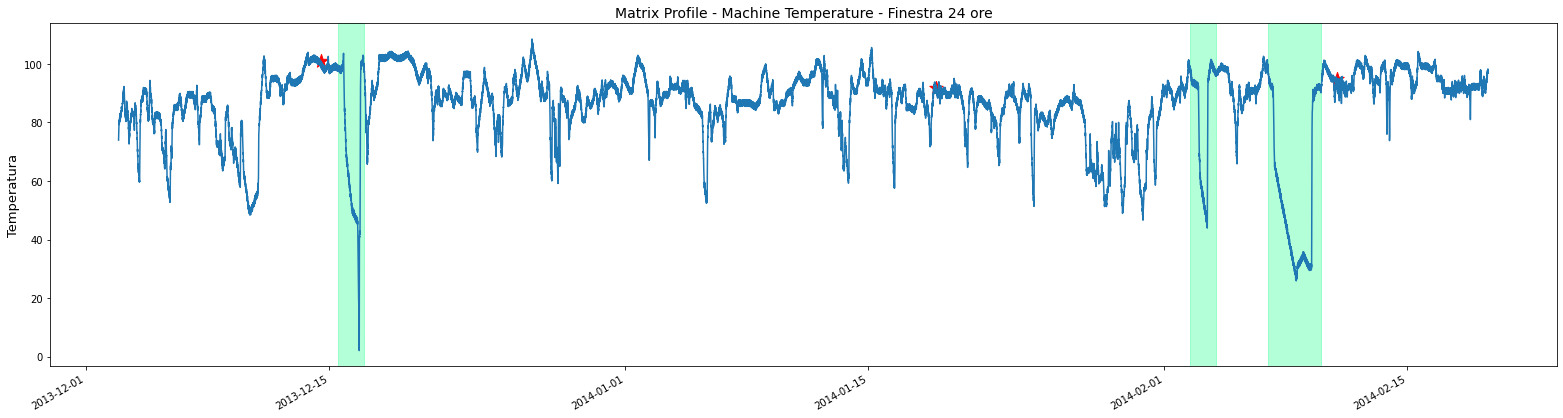

In [108]:
# Plot dei risultati

fig, ax = plt.subplots(1, figsize=(27, 7))
(temp2['value']).plot(ax=ax)
#(taxi2['value'][discords_timestamps]).plot(ax=ax)

for event, duration in events.items():
    start, end = duration
    ax.axvspan(start, end, alpha=0.3,
                  color='springgreen')
    
ax.scatter(discords_timestamps, temp2['value'][discords_timestamps], color='r', marker='*', s=200)

ax.set_xlabel('')
ax.set_xlabel('')

ax.set_ylabel('Temperatura', size=13)
ax.set_title('Matrix Profile - Machine Temperature - Finestra 24 ore',size=14)

fig.savefig('MP_MachineTemp_24H.png')
plt.show()